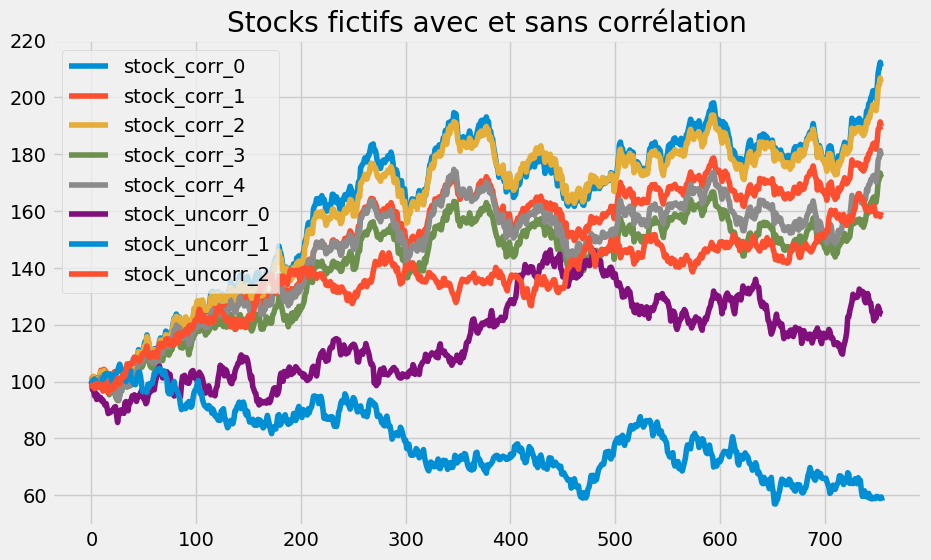


Matrice de corrélation:
                stock_corr_0  stock_corr_1  stock_corr_2  stock_corr_3   
stock_corr_0        1.000000      0.996074      0.997172      0.993541  \
stock_corr_1        0.996074      1.000000      0.996052      0.987310   
stock_corr_2        0.997172      0.996052      1.000000      0.992972   
stock_corr_3        0.993541      0.987310      0.992972      1.000000   
stock_corr_4        0.994144      0.985178      0.991911      0.996808   
stock_uncorr_0      0.685825      0.710223      0.720085      0.701973   
stock_uncorr_1     -0.798485     -0.819362     -0.821004     -0.766480   
stock_uncorr_2      0.868146      0.885735      0.864794      0.831169   

                stock_corr_4  stock_uncorr_0  stock_uncorr_1  stock_uncorr_2  
stock_corr_0        0.994144        0.685825       -0.798485        0.868146  
stock_corr_1        0.985178        0.710223       -0.819362        0.885735  
stock_corr_2        0.991911        0.720085       -0.821004        0.8

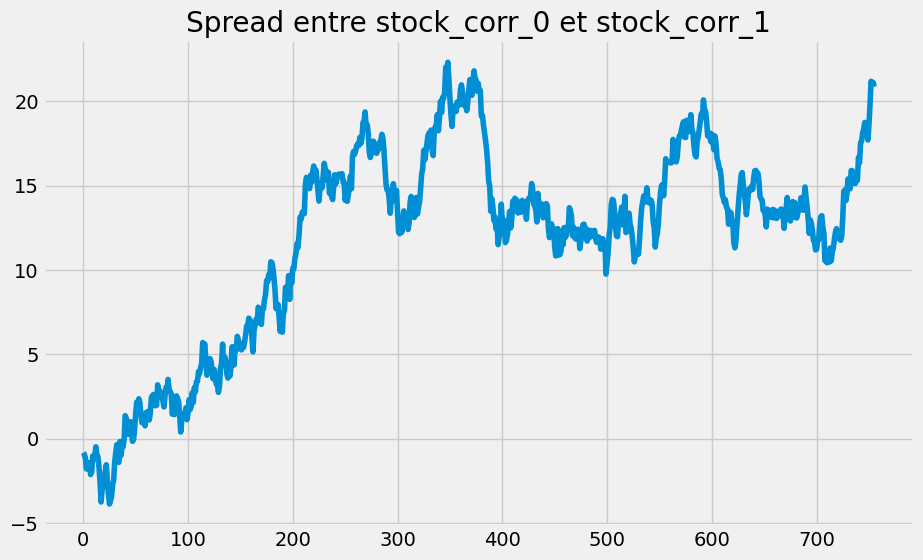

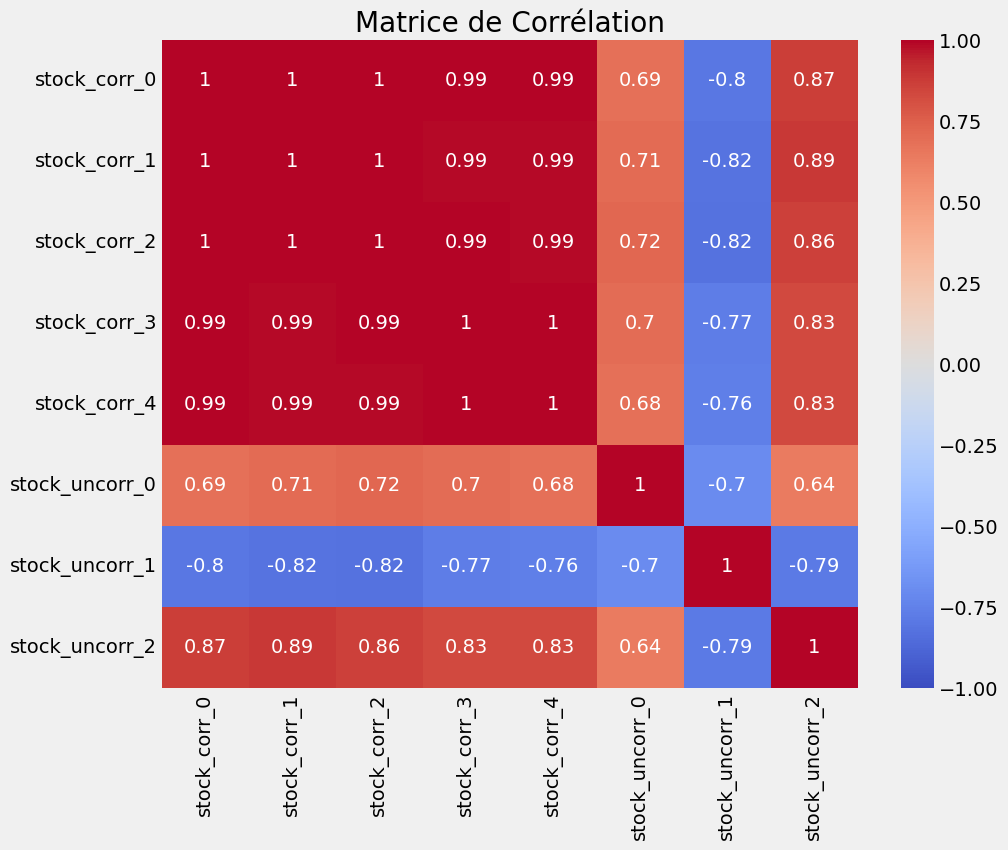

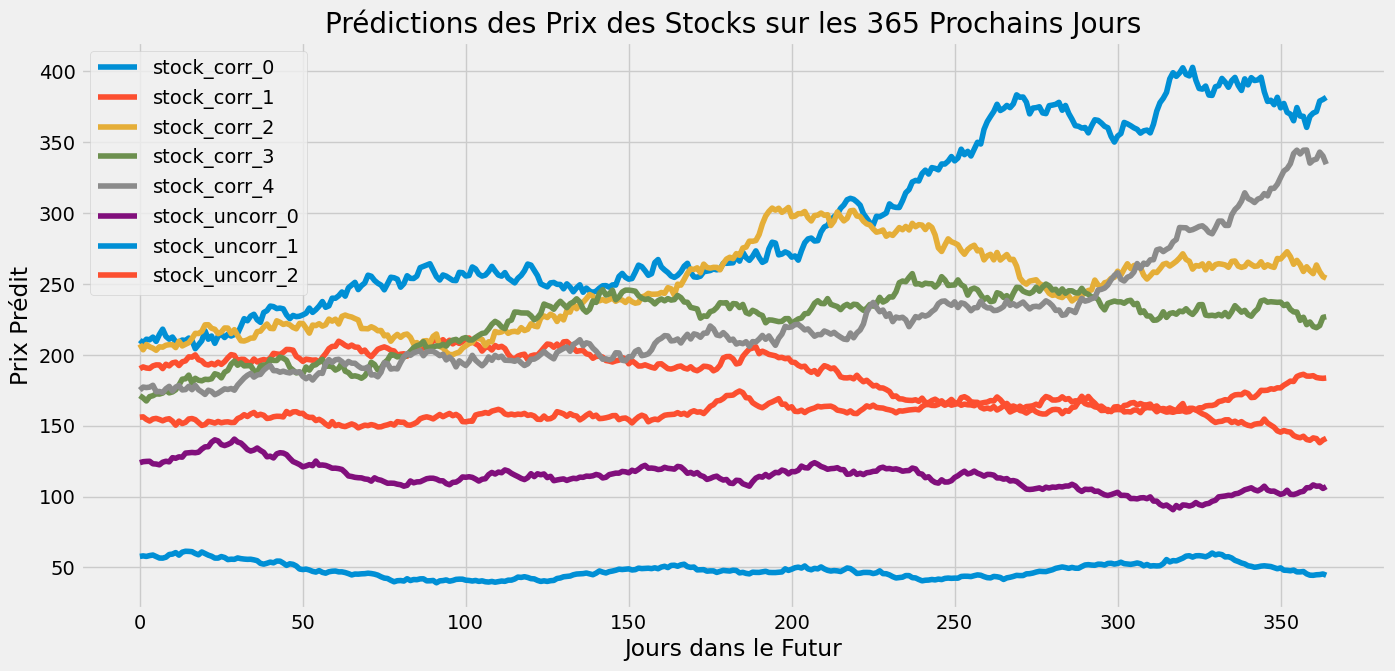

La paire de stocks ayant la plus grande corrélation à t-1 est: ('stock_corr_0', 'stock_uncorr_2') avec une corrélation de 0.06


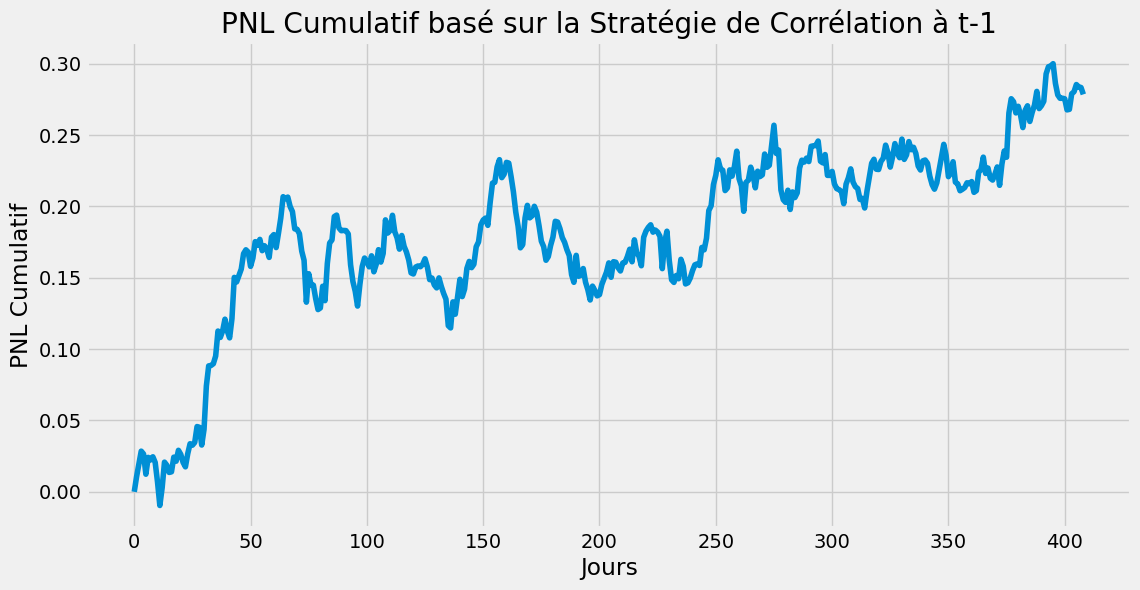

Résultat final après la période de simulation: 0.28


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#I)

# 1. Définir la matrice de corrélation
n_assets = 5
corr_target = np.full((n_assets, n_assets), 0.98)
np.fill_diagonal(corr_target, 1.0)

# 2. Utiliser la décomposition de Cholesky
chol_decomp = np.linalg.cholesky(corr_target)

# 3. Générer des séries temporelles multivariées
n_days = 3 * 252  # 3 ans de jours ouvrés
mean_returns = [0.0005, 0.0004, 0.0003, 0.0002, 0.0001]
volatilities = [0.02, 0.015, 0.018, 0.016, 0.017]

random_returns = np.random.randn(n_days, n_assets)
corr_returns = np.dot(random_returns, chol_decomp.T)
corr_returns = corr_returns * volatilities + mean_returns

prices = pd.DataFrame(corr_returns).cumsum()
prices = prices.apply(lambda x: (x + 1) * 100)  

# Nommez les colonnes pour éviter les doublons
prices.columns = ["stock_corr_" + str(i) for i in range(n_assets)]

# Ajouter 3 stocks supplémentaires sans corrélation
n_new_assets = 3
mean_returns_new = [0.0003, 0.0002, 0.0003]
volatilities_new = [0.015, 0.014, 0.013]

for i in range(n_new_assets):
    random_returns_new = np.random.randn(n_days) * volatilities_new[i] + mean_returns_new[i]
    prices_new = pd.Series(random_returns_new).cumsum()
    prices_new = (prices_new + 1) * 100
    prices["stock_uncorr_" + str(i)] = prices_new  # Nommez la nouvelle colonne

#II)

# Visualiser
prices.plot(figsize=(10, 6))
plt.title("Stocks fictifs avec et sans corrélation")
plt.show()

# Calcul de la matrice de corrélation
correlation_matrix = prices.corr()
print("\nMatrice de corrélation:")
print(correlation_matrix)

#III)


# Calcul du spread entre les deux premiers stocks
spread = prices["stock_corr_0"] - prices["stock_corr_1"]
spread.plot(figsize=(10, 6))
plt.title("Spread entre stock_corr_0 et stock_corr_1")
plt.show()

# # Affichage de la matrice de corrélation avec une heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show()

def trade_on_spread(prices, stock_a, stock_b):
    # Calcul du spread entre les deux stocks choisis
    spread = prices[stock_a] - prices[stock_b]

    # Calcul de la moyenne et de l'écart-type du spread
    mean_spread = spread.mean()
    std_spread = spread.std()

    # Définir le seuil d'impact
    threshold = mean_spread + 2 * std_spread

    # Stratégie de trading basée sur le spread
    positions = []
    open_prices = []
    pnl = []

    for day in range(len(spread)):
        if spread[day] > threshold and not positions:  # Ouvrir un trade
            positions.append(-1)
            open_prices.append(spread[day])
        elif spread[day] <= mean_spread and positions:  # Clôturer un trade
            close_price = spread[day]
            for open_price in open_prices:
                pnl.append(open_price - close_price)
            positions = []
            open_prices = []

    if positions:
        close_price = spread.iloc[-1]
        for open_price in open_prices:
            pnl.append(open_price - close_price)

    total_pnl = sum(pnl)

    # Résumé des opérations de trading
    num_opened_trades = len([p for p in pnl if p > 0])
    num_closed_trades = len(pnl)
    average_pnl_per_trade = total_pnl / num_closed_trades if num_closed_trades != 0 else 0

    print("\nRésumé des opérations de trading :")
    print(f"- Nombre de trades ouverts : {num_opened_trades}")
    print(f"- Nombre de trades clôturés : {num_closed_trades}")
    print(f"- PNL moyen par trade : {average_pnl_per_trade:.2f}")
    print(f"- PNL total : {total_pnl:.2f}")
    print(f"- Trades effectués entre les stocks : {stock_a} et {stock_b}")
    print(f"    -> Vendre {stock_a} et Acheter {stock_b} lorsque le spread est au-dessus du seuil.")
    print(f"    -> Acheter {stock_a} et Vendre {stock_b} lorsque le spread est en dessous de la moyenne.\n")

    # Visualisation
    spread.plot(figsize=(12, 7))
    plt.axhline(mean_spread, color='green', linestyle='--', label="Moyenne du Spread")
    plt.axhline(threshold, color='red', linestyle='--', label="Seuil d'Impact")
    plt.legend()
    plt.title(f"Spread entre {stock_a} et {stock_b} avec Points de Trading")
    for day in range(len(spread)):
        if spread[day] > threshold:
            plt.scatter(day, spread[day], color='red', zorder=5)
        elif spread[day] <= mean_spread:
            plt.scatter(day, spread[day], color='green', zorder=5)
    plt.show()


def simulate_gbm(prices, days, dt=1):
    """
    Simule le mouvement brownien géométrique pour la prédiction des prix futurs.
    """
    predictions = {}

    for stock in prices.columns:
        # Calcul du rendement moyen et de la volatilité
        returns = prices[stock].pct_change().dropna()
        mu = returns.mean()
        sigma = returns.std()

        # Dernier prix connu
        last_price = prices[stock].iloc[-1]

        # Simuler le mouvement brownien géométrique
        simulation = [last_price]
        for day in range(days):
            delta_W = np.random.normal(0, np.sqrt(dt))
            delta_S = mu * simulation[-1] * dt + sigma * simulation[-1] * delta_W
            simulation.append(simulation[-1] + delta_S)

        predictions[stock] = simulation[1:]

    return pd.DataFrame(predictions)


# # Appeler la fonction avec les noms des stocks de votre choix
# trade_on_spread(prices, 'stock_corr_0', 'stock_corr_1')

# Simuler les prix pour les 365 prochains jours
days_ahead = 365
future_prices = simulate_gbm(prices, days_ahead)

# Affichage des prédictions
future_prices.plot(figsize=(15, 7))
plt.title("Prédictions des Prix des Stocks sur les 365 Prochains Jours")
plt.xlabel("Jours dans le Futur")
plt.ylabel("Prix Prédit")
plt.show()


# 1. Calculer les rendements quotidiens
returns = prices.pct_change().dropna()

# 2. Calculer la corrélation des rendements de chaque stock avec le rendement à t-1 des autres stocks
max_corr_value = -1  # valeur initiale
stock_pair = None

for col1 in returns.columns:
    for col2 in returns.columns:
        if col1 != col2:
            correlation = returns[col1].iloc[1:].corr(returns[col2].shift(1).dropna())
            if correlation > max_corr_value:
                max_corr_value = correlation
                stock_pair = (col1, col2)

print(f"La paire de stocks ayant la plus grande corrélation à t-1 est: {stock_pair} avec une corrélation de {max_corr_value:.2f}")

# 3. Stratégie de trading basée sur cette corrélation
positions = []
pnl = []

for i in range(1, len(returns)):
    # Si le stock 1 monte, acheter le stock 2
    if returns[stock_pair[0]].iloc[i] > 0:
        positions.append(returns[stock_pair[1]].iloc[i])

# Calculer le PNL cumulatif
cumulative_pnl = np.cumsum(positions)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_pnl)
plt.title("PNL Cumulatif basé sur la Stratégie de Corrélation à t-1")
plt.xlabel("Jours")
plt.ylabel("PNL Cumulatif")
plt.grid(True)
plt.show()

# Imprimer le PNL final
final_pnl = cumulative_pnl[-1]
print(f"Résultat final après la période de simulation: {final_pnl:.2f}")

SyntaxError: invalid syntax (3277417328.py, line 1)

In [6]:
import pandas_ta as ta
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import plotly.io as pio

import plotly.io as pio
pio.renderers.default = "firefox"


pyo.init_notebook_mode(connected=True)

# get ticker data
#df = pd.read_csv('EURUSD=X.csv')
# Simuler le dataframe df
np.random.seed(43)  # seed pour la reproductibilité
n = 100  # nombre de jours
dates = pd.date_range("20230101", periods=n)
open_prices = np.cumsum(np.random.randn(n)) + 100  # prix d'ouverture
close_prices = open_prices + np.random.randn(n) * 0.5  # prix de clôture
low_prices = np.minimum(open_prices, close_prices) - np.abs(np.random.randn(n) * 0.5)  # prix bas
high_prices = np.maximum(open_prices, close_prices) + np.abs(np.random.randn(n) * 0.5)  # prix haut
volumes = np.random.randint(1000, 10000, size=n)  # volumes

df = pd.DataFrame({
    'Open': open_prices,
    'Close': close_prices,
    'Low': low_prices,
    'High': high_prices,
    'Volume': volumes
}, index=dates)

# Sélectionner les colonnes requises et les renommer
df = df[['Open', 'Close', 'Low', 'High', 'Volume']]
df.columns = ['Open', 'Close', 'Low', 'High', 'Volume']
# calculate MACD values
df.ta.macd(close='close', fast=12, slow=26, append=True)

# Force lowercase (optional)
df.columns = [x.lower() for x in df.columns]
print(df)

# Construct a 2 x 1 Plotly figure
fig = make_subplots(rows=2, cols=1)

# price Line
fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['open'],
        line=dict(color='#ff9900', width=1),
        name='open',
        # showlegend=False,
        legendgroup='1',

    ), row=1, col=1
)

# Candlestick chart for pricing
fig.append_trace(
    go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='#ff9900',
        decreasing_line_color='black',
        showlegend=False

    ), row=1, col=1
)

# Fast Signal (%k)
fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['macd_12_26_9'],
        line=dict(color='#ff9900', width=2),
        name='macd',
        # showlegend=False,
        legendgroup='2',

    ), row=2, col=1
)

# Slow signal (%d)
fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['macds_12_26_9'],
        line=dict(color='#000000', width=2),
        # showlegend=False,
        legendgroup='2',
        name='signal'
    ), row=2, col=1
)

# Colorize the histogram values
colors = np.where(df['macdh_12_26_9'] < 0, '#000', '#ff9900')

# Plot the histogram
fig.append_trace(
    go.Bar(
        x=df.index,
        y=df['macdh_12_26_9'],
        name='histogram',
        marker_color=colors,

    ), row=2, col=1
)

# Make it pretty
layout = go.Layout(
    plot_bgcolor='#efefef',
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        )
    )
)


fig.update_layout(layout)
fig.show()


                  open       close         low        high  volume   
2023-01-01  100.257400  100.359238   99.237950  100.792397    9778  \
2023-01-02   99.348918   98.420658   98.228253   99.890772    4367   
2023-01-03   98.970415   99.159510   98.620152   99.722971    2196   
2023-01-04   98.435500   99.053570   97.686922   99.271683    3510   
2023-01-05   99.293573   98.948587   98.899615   99.438231    1300   
...                ...         ...         ...         ...     ...   
2023-04-06  104.372303  104.359612  104.020206  104.665201    8442   
2023-04-07  104.469234  104.571881  103.717390  104.717605    7245   
2023-04-08  104.280850  103.669030  103.432832  104.786133    6377   
2023-04-09  105.872452  106.106167  105.417815  106.650649    2786   
2023-04-10  106.458263  106.476613  106.379349  106.531882    5279   

            macd_12_26_9  macdh_12_26_9  macds_12_26_9  
2023-01-01           NaN            NaN            NaN  
2023-01-02           NaN            NaN      

                  Close
2020-01-02  7024.835708
2020-01-03  7017.922493
2020-01-04  7050.306919
2020-01-05  7126.458412
2020-01-06  7114.750744
...                 ...
2021-08-27  6697.425227
2021-08-28  6718.096972
2021-08-29  6811.936763
2021-08-30  6773.247303
2021-08-31  6711.014568

[608 rows x 1 columns]


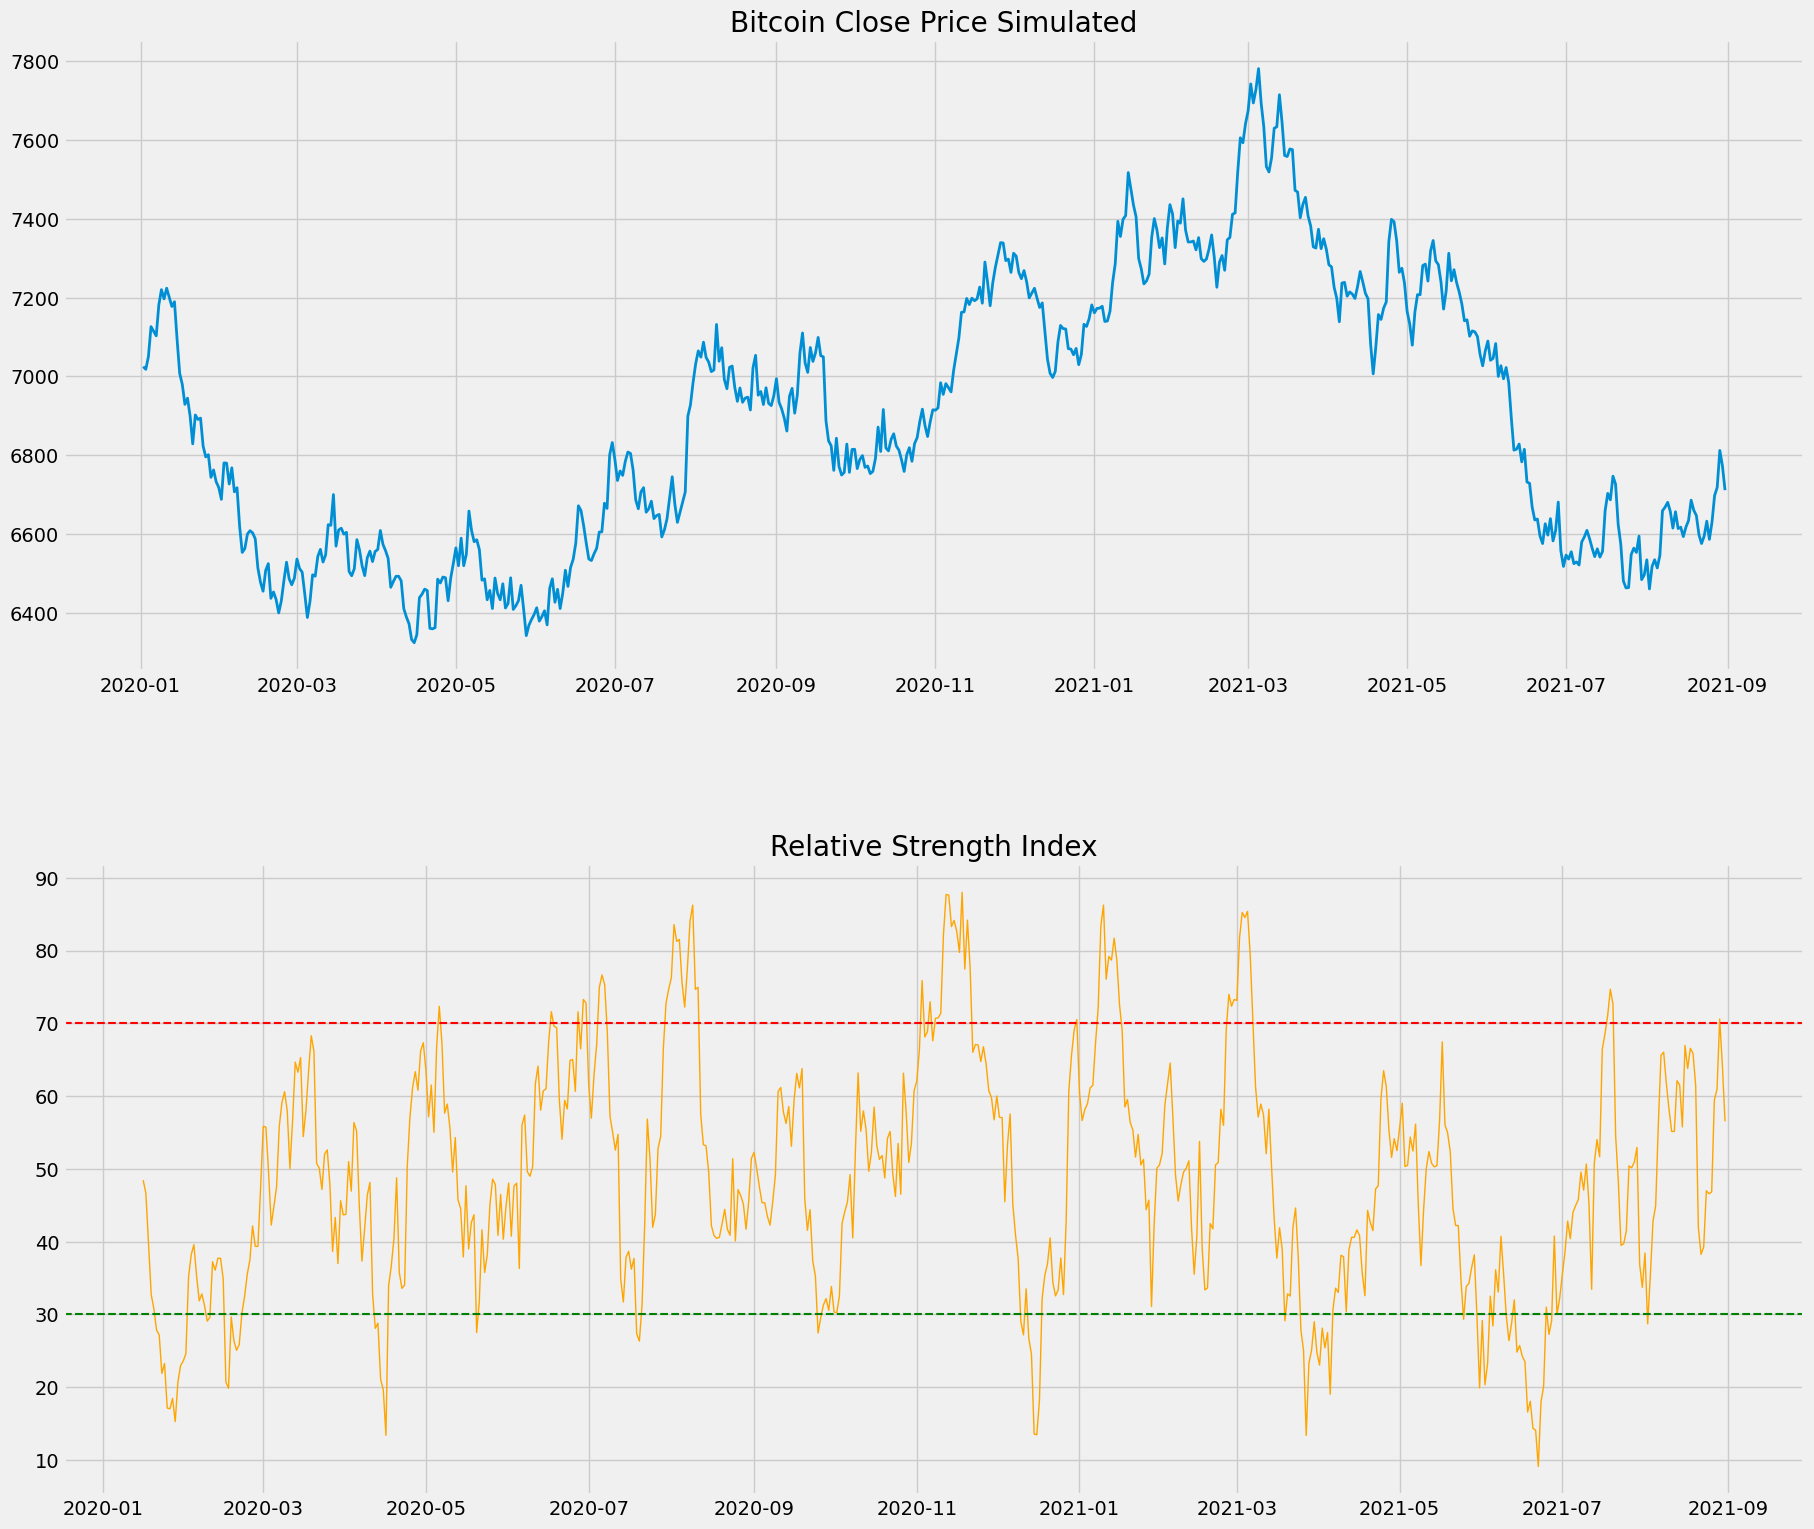

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Simuler les données
dates = pd.date_range(start="2020-01-02", end="2021-08-31", freq='D')
n = len(dates)
np.random.seed(42)  # creation de la seed
close_prices = 7000 + np.cumsum(np.random.randn(n) * 50)  # Génération d'un mouvement aléatoire autour de 7000$

df_btc = pd.DataFrame(data={'Close': close_prices}, index=dates)

# Print the result
print(df_btc)

# Calculer le changement quotidien du prix de fermeture
change = df_btc["Close"].diff()
change.dropna(inplace=True)

# Créer deux copies de la série de changement
change_up = change.copy()
change_down = change.copy()

# Isoler les gains et les pertes
change_up[change_up<0] = 0
change_down[change_down>0] = 0

# Vérification
change.equals(change_up+change_down)

# Calculer la moyenne mobile des gains et des pertes
avg_up = change_up.rolling(14).mean()
avg_down = change_down.rolling(14).mean().abs()

rsi = 100 * avg_up / (avg_up + avg_down)

# Configurer le style du graphique
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 20)

# Création des graphiques
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)

# Premier graphique: prix de fermeture
ax1.plot(df_btc['Close'], linewidth=2)
ax1.set_title('Bitcoin Close Price Simulated')

# Deuxième graphique: RSI
ax2.set_title('Relative Strength Index')
ax2.plot(rsi, color='orange', linewidth=1)
ax2.axhline(30, linestyle='--', linewidth=1.5, color='green')
ax2.axhline(70, linestyle='--', linewidth=1.5, color='red')

# Afficher les graphiques
plt.show()